In [1]:
import os
import csv
import json
import shelve

from PIL import Image
import matplotlib.pyplot as plt
from util.visualize import show_pyg_graph
import networkx as nx
from IPython.display import clear_output
from tqdm import tqdm

import spacy
nlp = spacy.load("en_core_web_sm")

from data.ag.action_genome import AG

%load_ext autoreload


In [2]:
root = '/data/Datasets/ag/'
subset_filename = 'data/ag/subset.json'
ag = AG(root)

folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/QQ9RN.mp4 does not exist
folder /data/Datasets/ag/frames/8EYHC.mp4 does not exist
folder /data/Datasets/ag/frames/8EYHC.mp4 does not exist
folder /data/Datasets/ag/frames/RTULL.mp4 does not exist
folder /data/Datasets/ag/frames/VKLP7.mp4 does not exist
folder /data/Datasets/ag/frames

In [3]:
for a in ag.action_classes:
    print(a)

c000 Holding some clothes
c001 Putting clothes somewhere
c002 Taking some clothes from somewhere
c003 Throwing clothes somewhere
c004 Tidying some clothes
c005 Washing some clothes
c006 Closing a door
c007 Fixing a door
c008 Opening a door
c009 Putting something on a table
c010 Sitting on a table
c011 Sitting at a table
c012 Tidying up a table
c013 Washing a table
c014 Working at a table
c015 Holding a phone/camera
c016 Playing with a phone/camera
c017 Putting a phone/camera somewhere
c018 Taking a phone/camera from somewhere
c019 Talking on a phone/camera
c020 Holding a bag
c021 Opening a bag
c022 Putting a bag somewhere
c023 Taking a bag from somewhere
c024 Throwing a bag somewhere
c025 Closing a book
c026 Holding a book
c027 Opening a book
c028 Putting a book somewhere
c029 Smiling at a book
c030 Taking a book from somewhere
c031 Throwing a book somewhere
c032 Watching/Reading/Looking at a book
c033 Holding a towel/s
c034 Putting a towel/s somewhere
c035 Taking a towel/s from somewh

In [4]:
for b in ag.object_classes:
    print(b)

__background__
person
bag
bed
blanket
book
box
broom
chair
closet/cabinet
clothes
cup/glass/bottle
dish
door
doorknob
doorway
floor
food
groceries
laptop
light
medicine
mirror
paper/notebook
phone/camera
picture
pillow
refrigerator
sandwich
shelf
shoe
sofa/couch
table
television
towel
vacuum
window


In [5]:
print(len(ag))

33432


INDEX: 1060
VALIDITY: UNMARKED
c009 Putting something on a table
VIDEO-FRAME-ACTION ID: HOI88.mp4/000083.png_9
[('person', 'not_looking_at', 'table'), ('table', 'in_front_of', 'person'), ('person', 'touching', 'table')]


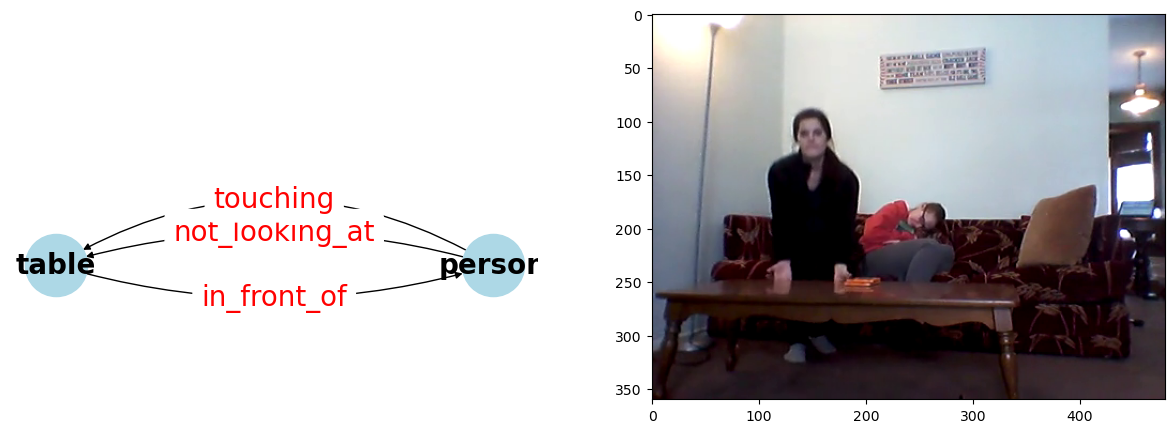

In [33]:
%autoreload

with shelve.open('data/ag/subset_shelve') as subset_dict:
    index = 0
    while True:

        if index >= len(ag) or index < 0:
            print('out of bounds index, returning to index 0')
            index = 0
            break

        clear_output(wait=True)

        id, img, sg, action = ag[index]
        print('INDEX:', index)
        print('VALIDITY:', subset_dict[id] if id in subset_dict else 'ABSENT')
        print(ag.action_classes[action])
        print('VIDEO-FRAME-ACTION ID:', id)
        nodes = [ag.object_classes[t] for t in sg.node_type]
        print([ (nodes[sg.edge_index[0][i].item()], \
                ag.relationship_classes[t], \
                nodes[sg.edge_index[1][i].item()], \
                ) for i,t in enumerate(sg.edge_type)])

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        show_pyg_graph(sg, ag.object_classes, ag.relationship_classes, layout='circular', curve=0.1, ax=axs[0])
        axs[1].imshow(img)
        plt.show(fig)

        selected_action = None

        answer = input('Enter to continue, space to mark invalid, m to mark valid, p to flag, q to quit, b to go back, n to jump to next unmarked, f to jump to next flagged, or type an index to jump to')
        if answer == 'q':
            confirm = input('quitting, enter to continue, space to cancel')
            if confirm == ' ':
                continue
            else:
                break
        elif answer == '':
            if selected_action is not None:
            if index == len(ag) - 1:
                _ = input('max index reached, enter to continue')
                continue
            index += 1
        elif answer == 'b':
            if index == 0:
                _ = input('first index reached, enter to continue')
                continue
            index -= 1
        elif answer == 'm':
            subset_dict[id] = str(True)

            if index == len(ag) - 1:
                _ = input('max index reached, enter to continue')
                continue
            index += 1
        elif answer == ' ':
            subset_dict[id] = str(False)

            if index == len(ag) - 1:
                _ = input('max index reached, enter to continue')
                continue
            index += 1
        elif answer == 'p':
            subset_dict[id] = 'FLAGGED'

            if index == len(ag) - 1:
                _ = input('max index reached, enter to continue')
                continue
            index += 1
        elif answer == 'n': #next unmarked
            while True:
                if index >= len(ag) - 1:
                    _ = input('max index reached, enter to continue')
                    break
                index += 1
                id, _, _, _ = ag[index]
                if subset_dict[id] == 'UNMARKED':
                    break
        elif answer == 'f': #next flagged
            while True:
                if index >= len(ag) - 1:
                    _ = input('max index reached, enter to continue')
                    break
                index += 1
                id, _, _, _ = ag[index]
                if subset_dict[id] == 'FLAGGED':
                    break
        elif answer[0] == 'c':
            action_number = int(answer[1:])
            while True:
                if index >= len(ag) - 1:
                    _ = input('max index reached, enter to continue')
                    break
                index += 1
                id, _, _, action = ag[index]
                if action == action_number:
                    break
        elif answer[0] == 'C':
            action_number = int(answer[1:])
            while True:
                if index >= len(ag) - 1:
                    _ = input('max index reached, enter to continue')
                    break
                index += 1
                id, _, _, action = ag[index]
                if action == action_number:
                    break
        else:
            try: 
                goto_idx = int(answer)
                if goto_idx < 0 or goto_idx >= len(ag):
                    _ = input('out of bounds index, enter to continue')
                    continue
                index = goto_idx
            except ValueError:
                _ = input('invalid index, enter to continue')


In [ ]:
#apply some initial heuristics

with shelve.open('data/ag/subset_shelve') as subset_dict:
    for idx in range(len(ag)):
        id, img, sg, action = ag[index]

        pos = {}
        doc = nlp(action)
        for tok in doc:
            pos[tok.pos_].append(tok.text)
        print(pos['VERB'])

In [ ]:
for i,action in enumerate(ag.action_classes):
    words = action.split(' ')[1:]
    
    action = ' '.join(words)
    doc = nlp(action)
    count = 0
    for tok in doc:
        if tok.pos_ == 'VERB':
            count+=1
            print(i, tok.text)
    if count > 1:
        print('double verb:', action)

0 Holding
1 Putting
2 Taking
3 Throwing
4 Tidying
5 Washing
6 Closing
7 Fixing
8 Opening
9 Putting
10 Sitting
11 Sitting
12 Tidying
13 Washing
14 Working
15 Holding
16 Playing
17 Putting
18 Taking
19 Talking
20 Holding
21 Opening
22 Putting
23 Taking
24 Throwing
25 Closing
26 Holding
27 Opening
28 Putting
29 Smiling
30 Taking
31 Throwing
32 Watching
32 Looking
double verb: Watching/Reading/Looking at a book
33 Holding
34 Putting
34 s
double verb: Putting a towel/s somewhere
35 Taking
36 Throwing
36 s
double verb: Throwing a towel/s somewhere
37 Tidying
38 Washing
39 Closing
40 Holding
41 Opening
42 Putting
43 Taking
44 Taking
45 Throwing
46 Closing
47 Holding
48 Opening
49 Putting
50 Taking
51 Watching
53 Holding
54 Putting
55 Putting
56 Taking
57 Taking
58 Throwing
59 Sitting
60 Standing
61 Holding
62 Putting
63 Taking
64 Throwing
65 Eating
66 Making
67 Holding
68 Putting
69 Taking
70 Holding
71 Putting
72 Snuggling
73 Taking
74 Throwing
75 Tidying
76 Holding
77 Putting
78 Snuggling
7

In [22]:
action_hist = {}
for idx in range(len(ag)):
    id, img, sg, action = ag[idx]

    if action not in action_hist:
        action_hist[action] = 0
    action_hist[action]+=1

In [32]:
sorted_actions = sorted(action_hist.items(), key=lambda x: x[1], reverse=True)

for k,v in sorted_actions:
    print(ag.action_classes[k], v)
#plt.hist(list(action_hist.values()), bins=range(1, 10))


c097 Walking through a doorway 1095
c154 Someone is standing up from somewhere 997
c106 Drinking from a cup/glass/bottle 833
c151 Someone is going from standing to sitting 714
c009 Putting something on a table 711
c152 Someone is smiling 684
c061 Holding some food 679
c156 Someone is eating something 633
c059 Sitting in a chair 633
c107 Holding a cup/glass/bottle of something 626
c008 Opening a door 586
c063 Taking food from somewhere 550
c015 Holding a phone/camera 540
c006 Closing a door 499
c001 Putting clothes somewhere 489
c118 Holding a dish 478
c153 Someone is sneezing 451
c113 Opening a closet/cabinet 450
c000 Holding some clothes 425
c110 Taking a cup/glass/bottle from somewhere 423
c020 Holding a bag 416
c062 Putting some food somewhere 406
c081 Putting something on a shelf 389
c109 Putting a cup/glass/bottle somewhere 384
c149 Someone is laughing 383
c141 Grasping onto a doorknob 372
c016 Playing with a phone/camera 369
c119 Putting a dish/es somewhere 368
c002 Taking some c

In [ ]:
init_dict = {}
for id, _, _, _ in tqdm(ag):
    init_dict[id] = 'UNMARKED'

In [9]:
#convert to shelve

filename = 'data/ag/subset.json'

# Step 1: Load the JSON-stored dictionary
with open(filename, 'r') as json_file:
    json_dict = json.load(json_file)  # Load the JSON file into a Python dictionary

# Step 2: Create and populate a shelve file
with shelve.open('data/ag/subset_shelve') as shelve_file:  # This creates a new shelve file (or opens an existing one)
    for key, value in json_dict.items():
        shelve_file[key] = str(value) # Store each key-value pair in the shelve file

print("JSON dictionary successfully converted to a shelve file!")

JSON dictionary successfully converted to a shelve file!
